# Project - Credit Card Fraud Detection

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035

# Aims of the Project
* Bu projede, veri setinde nadir olarak karşılaşılan ama aslında tespit etmeye çalıştığımız bir durum olan kredi kartı dolandırıcılığının tespiti üzerine yapılmış geçmiş çalışmalar incelenecektir.  
* Dersin ana konusu olan **veri madenciliği ve klasik makine öğrenmesi** konularına odaklanılacak ve bu konuların kredi kartı dolandırıcılığı tespiti üzerindeki etkileri incelenecektir.

# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [1]:
import logging
import logging.config
import yaml
import textwrap

class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


PROJECT_DIR = '/Users/ondergormez/Repos/BLM5116_Data_Mining_and_Knowledge_Discovery/03-Project/'
LOGGER_CONFIG_FILE = PROJECT_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.DEBUG)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[DEBUG] [2024-12-30T01:37:50.060Z] This is a debug message that will be wrapped after 140 characters. This is a debug
    message that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.
    This is a debug message that will be wrapped after 140 characters. This is a debug message that will be wrapped after
    140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message that will be
    wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters. This is a debug message
    that will be wrapped after 140 characters. This is a debug message that will be wrapped after 140 characters.

[INFO] [2024-12-30T01:37:50.061Z] Logging is configured successfully.


# Dataset Selection

Konu ile ilgili datasetler incelendiğinde okunacak makaleninde incelediği [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataseti üzerinde çalışılması uygun görülmüştür. 

* Bu dataset, 2013 yılında Avrupa'da 2 günde gerçekleşen kredi kartı işlemlerini içermektedir. Toplamda 284.807 işlem bulunmaktadır ve bu işlemlerden 492 tanesi dolandırıcılık içermektedir. Bu da **%0.172 dolandırıcılık oranına** denk gelmektedir.
* Bu dataset, **dengesiz (highly unbalanced)** bir datasettir ve dolandırıcılık işlemleri nadir olarak gerçekleşmektedir.
* Bu nedenle, bu dataset üzerinde çalışmak, kredi kartı dolandırıcılığı tespiti üzerindeki zorlukları daha iyi anlamamıza yardımcı olacaktır.

## Dataset Features

Veri setinin temel özellikleri;
* **Size:** 150.83 MB
* creditcard.csv
* Avrupa'da 2013 yılında yapılan işlemleri içerir
* 2 gün içinde gerçekleşen işlemler
* 284315 transfer içinde 492 fraud transfer
* Yüksek dengesizlik oranı (highly unbalanced)
* Yüzde 0.172 fraud transfer

# Dataset'in Yüklenmesi

[Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) dataseti indirilerek proje klasörüne koyulmuştur. Aşağıdaki şekilde projeye dahil edilmiştir.

* **V1, V2, ... V28** özellikleri, PCA ile elde edilen ana bileşenlerdir.
* PCA ile dönüştürülmeyen tek özellik 'Time' ve 'Amount' özellikleridir. 
  * **'Time' özelliği**, her işlem arasındaki geçen saniyeleri ve veri kümesindeki ilk işlem arasındaki saniyeleri içerir.
  * **'Amount' özelliği**, işlem miktarıdır, bu özellik 'example-dependant cost-sensitive learning' için kullanılabilir.
* **'Class' özelliği** yanıt değişkenidir ve **dolandırıcılık durumunda 1** değerini alır, **aksi takdirde 0** değerini alır.


In [2]:
import pandas as pd

FILE_PATH = PROJECT_DIR + 'creditcard.csv'

raw_data_df = pd.read_csv(FILE_PATH, sep=',')

logger.info("Columns of the raw dataframe: " + str(raw_data_df.columns))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-30T01:37:50.980Z] Columns of the raw dataframe: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
    'V8', 'V9', 'V10',        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',        'V21', 'V22',
    'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',        'Class'],       dtype='object')

[INFO] [2024-12-30T01:37:50.980Z] Shape of the dataframe: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Visualizing the Dataset Via Pie Chart

[INFO] [2024-12-30T01:37:51.108Z] Non-Fraud Transactions: 284315
[INFO] [2024-12-30T01:37:51.108Z] Fraud Transactions: 492


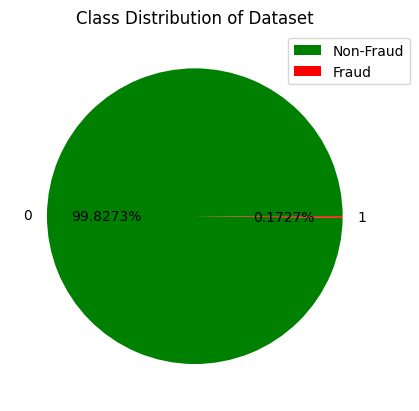

In [3]:
import matplotlib.pyplot as plt

class_column = 'Class'
class_counts = raw_data_df[class_column].value_counts()

# Class 0: Non-Fraud, Class 1: Fraud
logger.info("Non-Fraud Transactions: " + str(class_counts[0]))
logger.info("Fraud Transactions: " + str(class_counts[1]))

colors = ['green', 'red']
class_counts.plot.pie(autopct='%1.4f%%', startangle=0, colors=colors)
plt.title('Class Distribution of Dataset')
plt.ylabel('')
plt.legend(['Non-Fraud', 'Fraud'], loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()


# Splitting the Dataset into Train and Test Sets

* Yukarıda görüldüğü gibi veri seti evenly distributed değil.
* Bu nedenle veri setini train, validation ve test setlerine ayırırken stratify yaparak sınıfların dağılımını koruyacağız.


In [4]:
from sklearn.model_selection import train_test_split

# split the data features and target
X = raw_data_df.drop('Class', axis=1) # features
y = raw_data_df['Class'] # target

# TODO: Comment out the following line. This is useful for training the model with the small subset of the data.
# X, _, y, _ = train_test_split(X, y, test_size=0.70, random_state=578, stratify=y)
# logger.info("Shape of the new dataframe: " + str(X.shape))

# %60 train, %20 test, %20 validation olarak ayrılıyor.
# NOTE: Makalede validation set kullanılmadığı için burada da kullanılmayacak. Sonuçların karşılaştırması kolay olsun diye.
# stratify=y: y'yi dengeli bir şekilde bölmek için kullanılır. Veri seti bölünmeden önceki sınıf dağılımını korur.
# X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=578, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.5, random_state=578, stratify=y_other)

# %80 train, %20 test olarak ayrılıyor.
# stratify=y: y'yi dengeli bir şekilde bölmek için kullanılır. Veri seti bölünmeden önceki sınıf dağılımını korur.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=578, stratify=y)

logger.info(f"Train set size: {len(X_train)}")
# logger.info(f"Validation set size: {len(X_val)}")
logger.info(f"Test set size: {len(X_test)}")

[INFO] [2024-12-30T01:37:51.498Z] Train set size: 227845
[INFO] [2024-12-30T01:37:51.498Z] Test set size: 56962


Bölme işlemi sonrası her bir setin içerisinde bulunan class örneklerinin dağılımı aşağıdaki gibidir.

In [5]:
def print_class_distribution(y, name):
    # Class 0: Non-Fraud, Class 1: Fraud
    class_counts = y.value_counts()
    logger.info(f"Non-Fraud transactions in the {name} set: {class_counts[0]} samples, {class_counts[0] / len(y) * 100:.4f}%")
    logger.info(f"Fraud transactions in the {name} set: {class_counts[1]} samples, {class_counts[1] / len(y) * 100:.4f}%")
    logger.info("")
                                                                

print_class_distribution(y_train, "training")
# print_class_distribution(y_val, "validation")
print_class_distribution(y_test, "test")

[INFO] [2024-12-30T01:37:51.503Z] Non-Fraud transactions in the training set: 227451 samples, 99.8271%
[INFO] [2024-12-30T01:37:51.504Z] Fraud transactions in the training set: 394 samples, 0.1729%
[INFO] [2024-12-30T01:37:51.504Z] 
[INFO] [2024-12-30T01:37:51.505Z] Non-Fraud transactions in the test set: 56864 samples, 99.8280%
[INFO] [2024-12-30T01:37:51.506Z] Fraud transactions in the test set: 98 samples, 0.1720%
[INFO] [2024-12-30T01:37:51.506Z] 


# Metriklerin Hesaplanması

Modelin başarısının ölçümlenebilmesi için aşağıdaki metrikler kullanılacaktır.

## Accuracy

$$ \begin{equation} Accuracy = \frac{TP+TN}{TP+TN+FP+FN}\end{equation} $$

## Precision

$$ \begin{equation} Precision = \frac{TP}{TP+FP}\end{equation}  $$

## Recall

$$ \begin{equation} Recall = \frac{TP}{TP+FN}\end{equation}  $$

## F1 Score

$$ \begin{equation} F1 = \frac{2*Precision*Recall}{Precision+Recall}\end{equation}  $$

## Support

$$ \begin{equation} Support = TP+FN\end{equation}  $$

Yukarıdaki metrikleri her bir modelde tablo haline getirebilmek için aşağıdaki metod yazılmıştır.

# Metrics Code

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics_and_return_df(model, data_label, y_true, y_pred):

    # Calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    # pos_label='1' is used to calculate the metrics for the positive class: Fraud Transactions
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f_1_score = f1_score(y_true, y_pred, pos_label=1)
    support_for_fraud = y_true.value_counts()[1]

    # limit decimal point to 4 like 0.3682 in accuracy, precision, recall, and f1 score
    accuracy = f"{accuracy:.4f}"
    precision = f"{precision:.4f}"
    recall = f"{recall:.4f}"
    f_1_score = f"{f_1_score:.4f}"

    # Create a DataFrame
    metrics_df = pd.DataFrame({
        'Model': [model],
        'Data': [data_label],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f_1_score],
        'Support': [support_for_fraud]
    })

    print()
    
    return metrics_df

# Confusion Matrix Code

In [7]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Descision Tree Classifier

In [8]:
# Descision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

dt_calssifier = DecisionTreeClassifier(random_state=578)

# Train the classifier
dt_calssifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=578)

[INFO] [2024-12-30T01:38:01.962Z] Decision Tree Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,DT,Train,1.0000,1.0000,1.0000,1.0000,394


Confusion matrix, without normalization
[[227451      0]
 [     0    394]]


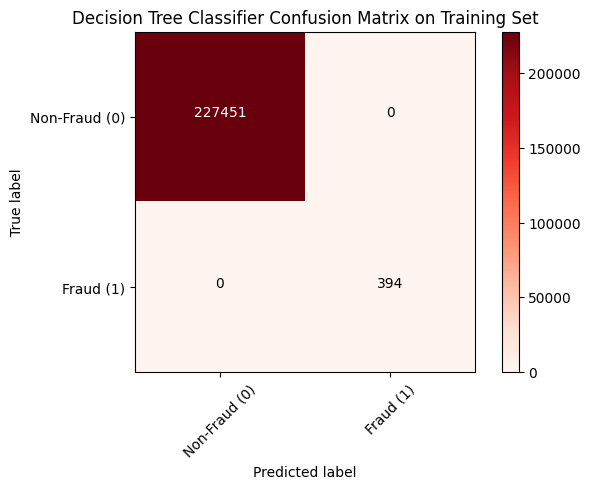

In [9]:
# Predict the training set
y_train_pred = dt_calssifier.predict(X_train)

logger.info("Decision Tree Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

dt_train_metrics_df = calculate_metrics_and_return_df('DT', 'Train', y_train, y_train_pred)
display(dt_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Decision Tree Classifier Confusion Matrix on Training Set')



In [10]:
# Predict the validation set
# y_val_pred = dt_calssifier.predict(X_val)
# 
# logger.info("Decision Tree Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred))
# 
# dt_val_metrics_df = calculate_metrics_and_return_df('DT', 'Validation', y_val, y_val_pred)
# display(dt_val_metrics_df)
# 
# 
# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Decision Tree Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T01:38:02.276Z] Decision Tree Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.73      0.73        98

    accuracy                           1.00     56962
   macro avg       0.87      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,DT,Test,0.9991,0.7347,0.7347,0.7347,98


Confusion matrix, without normalization
[[56838    26]
 [   26    72]]


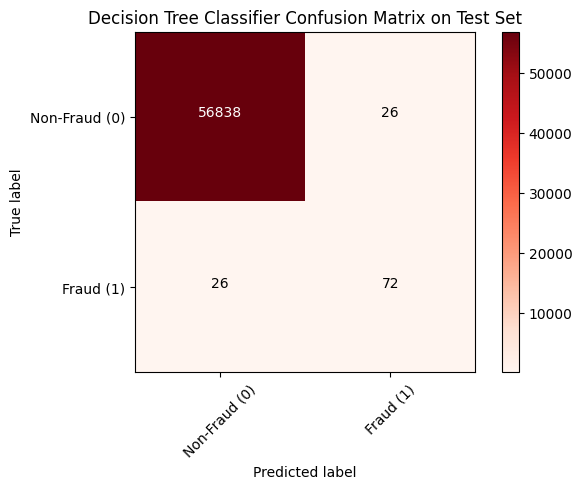

In [11]:
# Predict the test set
y_test_pred = dt_calssifier.predict(X_test)

logger.info("Decision Tree Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

dt_test_metrics_df = calculate_metrics_and_return_df('DT', 'Test', y_test, y_test_pred)
display(dt_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Decision Tree Classifier Confusion Matrix on Test Set')

In [12]:
# Print all metrics
dt_all_metrics_df = pd.concat([dt_train_metrics_df, dt_test_metrics_df]) # , dt_val_metrics_df
display(dt_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,DT,Train,1.0000,1.0000,1.0000,1.0000,394
0,DT,Test,0.9991,0.7347,0.7347,0.7347,98


# Logistic Regression Classifier

In [13]:
from sklearn.linear_model import LogisticRegression

log_regression_calssifier = LogisticRegression(random_state=33)
log_regression_calssifier.fit(X_train, y_train)

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=33)

[INFO] [2024-12-30T01:38:03.880Z] Logistic Regression Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.69      0.71      0.70       394

    accuracy                           1.00    227845
   macro avg       0.85      0.85      0.85    227845
weighted avg       1.00      1.00      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,LR,Train,0.9989,0.6915,0.7056,0.6985,394


Confusion matrix, without normalization
[[227327    124]
 [   116    278]]


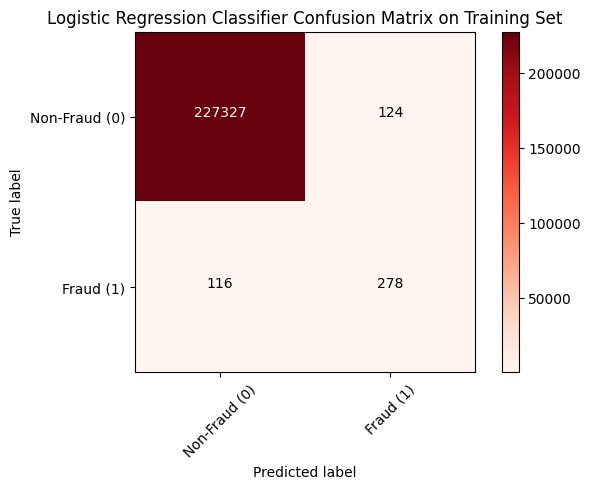

In [14]:
# Predict the training set
y_train_pred = log_regression_calssifier.predict(X_train)

logger.info("Logistic Regression Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

log_reg_train_metrics_df = calculate_metrics_and_return_df('LR', 'Train', y_train, y_train_pred)
display(log_reg_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Logistic Regression Classifier Confusion Matrix on Training Set')

In [15]:
# Predict the validation set
# y_val_pred = log_regression_calssifier.predict(X_val)
# 
# logger.info("Logistic Regression Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred))
# 
# log_reg_val_metrics_df = calculate_metrics_and_return_df('LR', 'Validation', y_val, y_val_pred)
# display(log_reg_val_metrics_df)
# 
# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Logistic Regression Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T01:38:04.226Z] Logistic Regression Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.67      0.63        98

    accuracy                           1.00     56962
   macro avg       0.80      0.84      0.82     56962
weighted avg       1.00      1.00      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,LR,Test,0.9987,0.6000,0.6735,0.6346,98


Confusion matrix, without normalization
[[56820    44]
 [   32    66]]


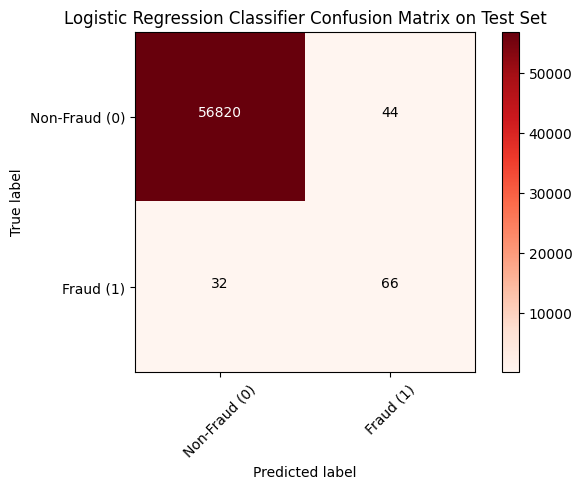

In [16]:
# Predict the test set
y_test_pred = log_regression_calssifier.predict(X_test)

logger.info("Logistic Regression Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

log_reg_test_metrics_df = calculate_metrics_and_return_df('LR', 'Test', y_test, y_test_pred)
display(log_reg_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Logistic Regression Classifier Confusion Matrix on Test Set')

In [17]:
# Print all metrics
log_reg_all_metrics_df = pd.concat([log_reg_train_metrics_df, log_reg_test_metrics_df]) # , log_reg_val_metrics_df
display(log_reg_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,LR,Train,0.9989,0.6915,0.7056,0.6985,394
0,LR,Test,0.9987,0.6000,0.6735,0.6346,98


# K-Nearest Neighbors Classifier (KNN)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

[INFO] [2024-12-30T01:38:27.983Z] K-Nearest Neighbors Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.97      0.10      0.18       394

    accuracy                           1.00    227845
   macro avg       0.99      0.55      0.59    227845
weighted avg       1.00      1.00      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,KNN,Train,0.9984,0.9750,0.0990,0.1797,394


Confusion matrix, without normalization
[[227450      1]
 [   355     39]]


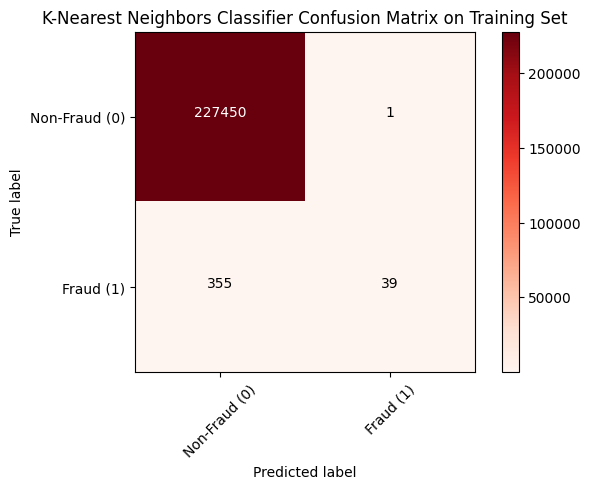

In [19]:
# Predict the training set
y_train_pred = knn_classifier.predict(X_train)

logger.info("K-Nearest Neighbors Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

knn_train_metrics_df = calculate_metrics_and_return_df('KNN', 'Train', y_train, y_train_pred)
display(knn_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='K-Nearest Neighbors Classifier Confusion Matrix on Training Set')

In [20]:
# Predict the validation set
# y_val_pred = knn_classifier.predict(X_val)
# 
# logger.info("K-Nearest Neighbors Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred))
# 
# knn_val_metrics_df = calculate_metrics_and_return_df('KNN', 'Validation', y_val, y_val_pred)
# display(knn_val_metrics_df)
# 
# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='K-Nearest Neighbors Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T02:03:55.842Z] K-Nearest Neighbors Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.04      0.08        98

    accuracy                           1.00     56962
   macro avg       1.00      0.52      0.54     56962
weighted avg       1.00      1.00      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,KNN,Test,0.9983,1.0000,0.0408,0.0784,98


Confusion matrix, without normalization
[[56864     0]
 [   94     4]]


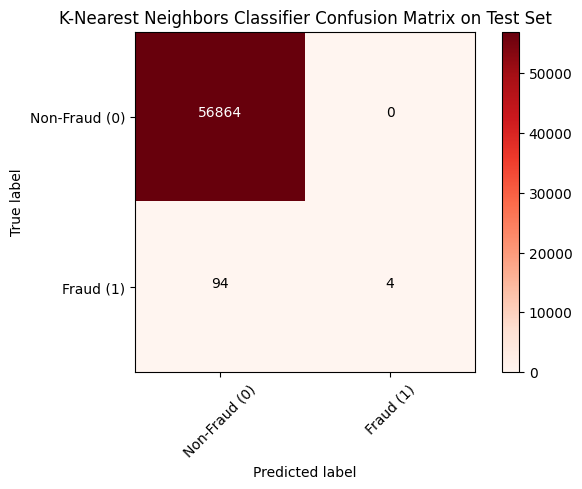

In [42]:
# Predict the test set
y_test_pred = knn_classifier.predict(X_test)

logger.info("K-Nearest Neighbors Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

knn_test_metrics_df = calculate_metrics_and_return_df('KNN', 'Test', y_test, y_test_pred)
display(knn_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='K-Nearest Neighbors Classifier Confusion Matrix on Test Set')

In [22]:
# Print all metrics
knn_all_metrics_df = pd.concat([knn_train_metrics_df, knn_test_metrics_df]) # , knn_val_metrics_df
display(knn_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,KNN,Train,0.9984,0.9750,0.0990,0.1797,394
0,KNN,Test,0.9983,1.0000,0.0408,0.0784,98


# Support Vector Machine (SVM)

In [23]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=33)

# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=33)

[INFO] [2024-12-30T01:42:19.159Z] Support Vector Machine Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.77      0.34      0.47       394

    accuracy                           1.00    227845
   macro avg       0.88      0.67      0.73    227845
weighted avg       1.00      1.00      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,SVM,Train,0.9987,0.7674,0.3350,0.4664,394


Confusion matrix, without normalization
[[227411     40]
 [   262    132]]


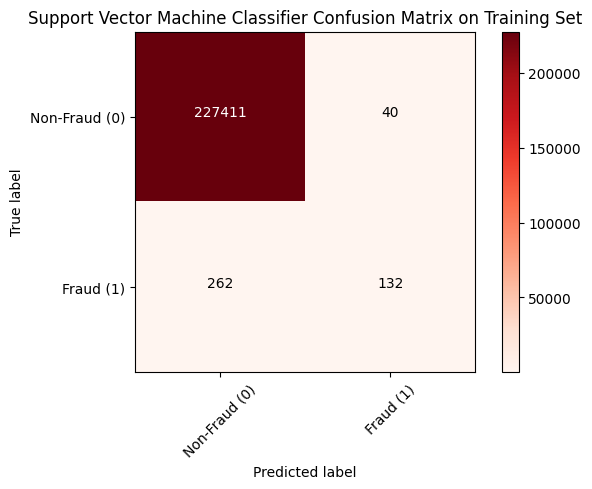

In [24]:
# Predict the training set
y_train_pred = svm_classifier.predict(X_train)

logger.info("Support Vector Machine Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

svm_train_metrics_df = calculate_metrics_and_return_df('SVM', 'Train', y_train, y_train_pred)
display(svm_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Support Vector Machine Classifier Confusion Matrix on Training Set')

In [25]:
# Predict the validation set
# y_val_pred = svm_classifier.predict(X_val)

# logger.info("Support Vector Machine Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred)

# svm_val_metrics_df = calculate_metrics_and_return_df('SVM', 'Validation', y_val, y_val_pred)
# display(svm_val_metrics_df)

# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Support Vector Machine Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T01:42:19.802Z] Support Vector Machine Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.31      0.43        98

    accuracy                           1.00     56962
   macro avg       0.86      0.65      0.71     56962
weighted avg       1.00      1.00      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,SVM,Test,0.9986,0.7143,0.3061,0.4286,98


Confusion matrix, without normalization
[[56852    12]
 [   68    30]]


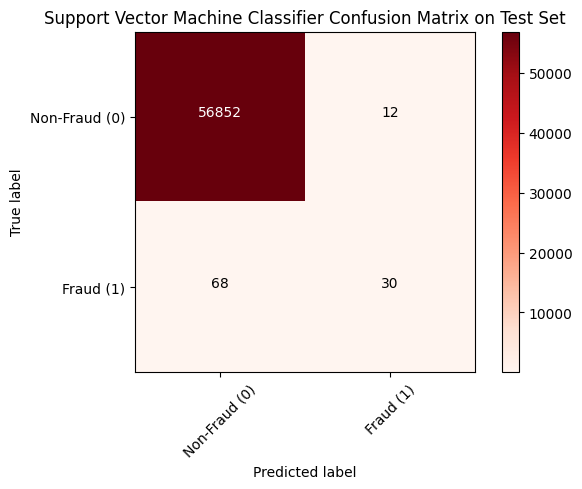

In [26]:
# Predict the test set
y_test_pred = svm_classifier.predict(X_test)

logger.info("Support Vector Machine Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

svm_test_metrics_df = calculate_metrics_and_return_df('SVM', 'Test', y_test, y_test_pred)
display(svm_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Support Vector Machine Classifier Confusion Matrix on Test Set')

In [27]:
# Print all metrics
svm_all_metrics_df = pd.concat([svm_train_metrics_df, svm_test_metrics_df]) # , svm_val_metrics_df
display(svm_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,SVM,Train,0.9987,0.7674,0.3350,0.4664,394
0,SVM,Test,0.9986,0.7143,0.3061,0.4286,98


# Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train the classifier
rf_classifier = RandomForestClassifier(random_state=33)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=33)

[INFO] [2024-12-30T01:44:06.485Z] Random Forest Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,RF,Train,1.0000,1.0000,0.9975,0.9987,394


Confusion matrix, without normalization
[[227451      0]
 [     1    393]]


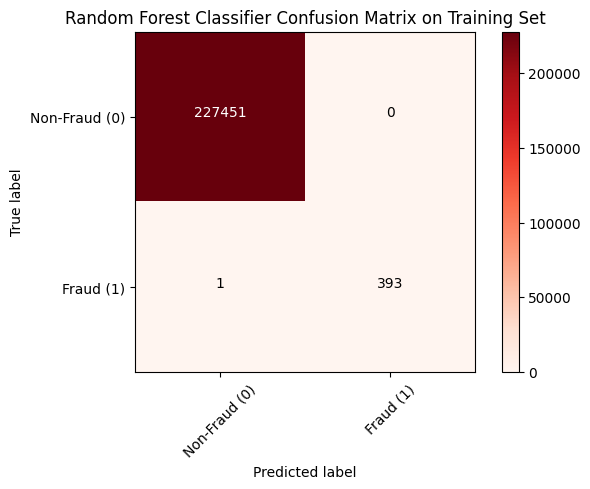

In [29]:
# Predict the training set
y_train_pred = rf_classifier.predict(X_train)

logger.info("Random Forest Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

rf_train_metrics_df = calculate_metrics_and_return_df('RF', 'Train', y_train, y_train_pred)
display(rf_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Random Forest Classifier Confusion Matrix on Training Set')


In [30]:
# Predict the validation set
# y_val_pred = rf_classifier.predict(X_val)

# logger.info("Random Forest Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred)

# rf_val_metrics_df = calculate_metrics_and_return_df('RF', 'Validation', y_val, y_val_pred)
# display(rf_val_metrics_df)

# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Random Forest Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T01:44:06.938Z] Random Forest Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,RF,Test,0.9995,0.9383,0.7755,0.8492,98


Confusion matrix, without normalization
[[56859     5]
 [   22    76]]


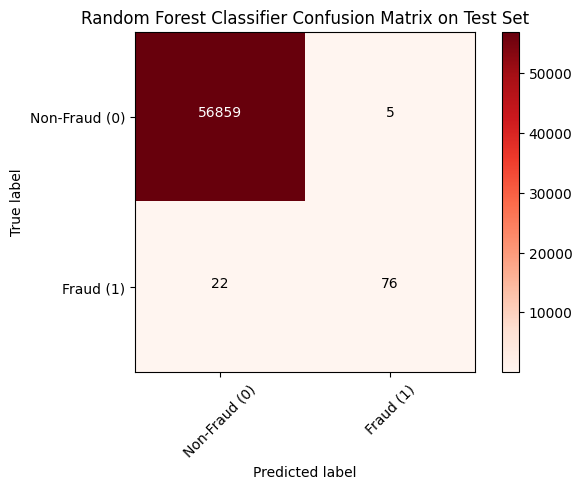

In [31]:
# Predict the test set
y_test_pred = rf_classifier.predict(X_test)

logger.info("Random Forest Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

rf_test_metrics_df = calculate_metrics_and_return_df('RF', 'Test', y_test, y_test_pred)
display(rf_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Random Forest Classifier Confusion Matrix on Test Set')

In [32]:
# Print all metrics
rf_all_metrics_df = pd.concat([rf_train_metrics_df, rf_test_metrics_df]) # , rf_val_metrics_df
display(rf_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,RF,Train,1.0000,1.0000,0.9975,0.9987,394
0,RF,Test,0.9995,0.9383,0.7755,0.8492,98


# Naive Bayes Classifier
Bu yöntem incelediğimiz paper da geçmemektedir. Fakat derste işlenen bir konu olduğu için eklenmiştir.

In [33]:
from sklearn.naive_bayes import GaussianNB

# Train the classifier
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

GaussianNB()

[INFO] [2024-12-30T01:44:07.132Z] Naive Bayes Classifier Results on the Training Set:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    227451
           1       0.15      0.63      0.24       394

    accuracy                           0.99    227845
   macro avg       0.57      0.81      0.62    227845
weighted avg       1.00      0.99      1.00    227845




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,NB,Train,0.9930,0.1470,0.6320,0.2385,394


Confusion matrix, without normalization
[[226006   1445]
 [   145    249]]


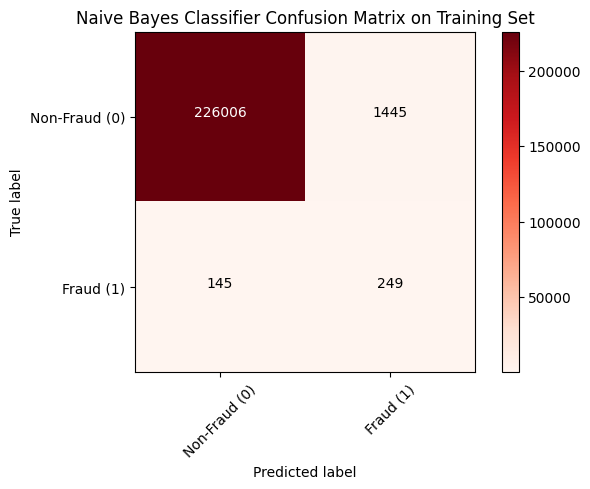

In [34]:
# Predict the training set
y_train_pred = nb_classifier.predict(X_train)

logger.info("Naive Bayes Classifier Results on the Training Set:")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

nb_train_metrics_df = calculate_metrics_and_return_df('NB', 'Train', y_train, y_train_pred)
display(nb_train_metrics_df)

cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Naive Bayes Classifier Confusion Matrix on Training Set')

In [35]:
# Predict the validation set
# y_val_pred = nb_classifier.predict(X_val)

# logger.info("Naive Bayes Classifier Results on the Validation Set:")
# print(classification_report(y_true=y_val, y_pred=y_val_pred)

# nb_val_metrics_df = calculate_metrics_and_return_df('NB', 'Validation', y_val, y_val_pred)
# display(nb_val_metrics_df)

# cm = confusion_matrix(y_val, y_val_pred)
# plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Naive Bayes Classifier Confusion Matrix on Validation Set')

[INFO] [2024-12-30T01:44:07.434Z] Naive Bayes Classifier Results on the Test Set:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.67      0.25        98

    accuracy                           0.99     56962
   macro avg       0.58      0.83      0.63     56962
weighted avg       1.00      0.99      1.00     56962




,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,NB,Test,0.9932,0.1568,0.6735,0.2543,98


Confusion matrix, without normalization
[[56509   355]
 [   32    66]]


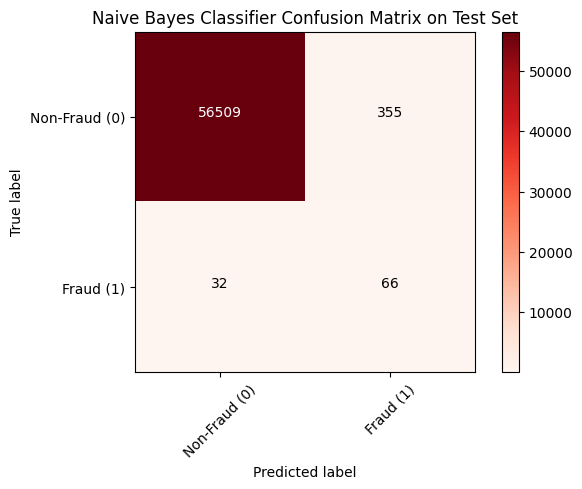

In [36]:
# Predict the test set
y_test_pred = nb_classifier.predict(X_test)

logger.info("Naive Bayes Classifier Results on the Test Set:")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

nb_test_metrics_df = calculate_metrics_and_return_df('NB', 'Test', y_test, y_test_pred)
display(nb_test_metrics_df)

cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=['Non-Fraud (0)', 'Fraud (1)'], title='Naive Bayes Classifier Confusion Matrix on Test Set')

In [37]:
# Print all metrics
nb_all_metrics_df = pd.concat([nb_train_metrics_df, nb_test_metrics_df]) # , nb_val_metrics_df
display(nb_all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,NB,Train,0.9930,0.1470,0.6320,0.2385,394
0,NB,Test,0.9932,0.1568,0.6735,0.2543,98


# Tüm Sonuçlar Üzerinde Karşılaştırma

Tüm sonuçların tablolaştırılmış hali aşağıdaki gibidir.

In [38]:
# Concatenate all metrics and display them
all_metrics_df = pd.concat([dt_all_metrics_df, log_reg_all_metrics_df, knn_all_metrics_df, svm_all_metrics_df, rf_all_metrics_df, nb_all_metrics_df])
display(all_metrics_df)

,Model,Data,Accuracy,Precision,Recall,F1 Score,Support
0,DT,Train,1.0000,1.0000,1.0000,1.0000,394
0,DT,Test,0.9991,0.7347,0.7347,0.7347,98
0,LR,Train,0.9989,0.6915,0.7056,0.6985,394
0,LR,Test,0.9987,0.6000,0.6735,0.6346,98
0,KNN,Train,0.9984,0.9750,0.0990,0.1797,394
0,KNN,Test,0.9983,1.0000,0.0408,0.0784,98
0,SVM,Train,0.9987,0.7674,0.3350,0.4664,394
0,SVM,Test,0.9986,0.7143,0.3061,0.4286,98
0,RF,Train,1.0000,1.0000,0.9975,0.9987,394
0,RF,Test,0.9995,0.9383,0.7755,0.8492,98


## Sonuçların Grafiksel Gösterimi

Sonuçların Accuracy ve F1 Score değerlerine göre grafiksel gösterimi aşağıdaki gibidir.

In [39]:
# Plot test metrics for all classifiers with accuracy, and f1 score

def plot_accuracy_and_f1_score_metrics(metrics_df, data_to_plot, title):
    # Filter the data
    data_to_plot_df = metrics_df[metrics_df['Data'] == data_to_plot]

    # convert to float numbers
    accuracy_list = data_to_plot_df['Accuracy'].astype(float)
    f1_score_list = data_to_plot_df['F1 Score'].astype(float)
    model_list = data_to_plot_df['Model'].tolist()

    n_of_models = len(model_list)
    # the label locations
    x = np.arange(n_of_models)

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.bar(x, f1_score_list, label='F1 Score', color='orange', width=0.4, alpha=0.9, align='center')
    plt.bar(x, accuracy_list, label='Accuracy', color='green', width=0.4, alpha=0.9, align='edge')

    # Add percentages on top of the bars
    for i, f1 in enumerate(f1_score_list):
        plt.text(i, float(f1) + 0.01, f1, ha='center', va = 'bottom')
    for i, accuracy in enumerate(accuracy_list):
        plt.text(i + 0.2, float(accuracy) + 0.01, accuracy, ha='center', va='bottom')


    plt.title(title)
    plt.xticks(x, model_list)
    plt.xlabel('Classifier')
    plt.ylabel('Metrics')
    # plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.ylim(0, 1.2)  # Set y-axis limits from 0 to 1
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


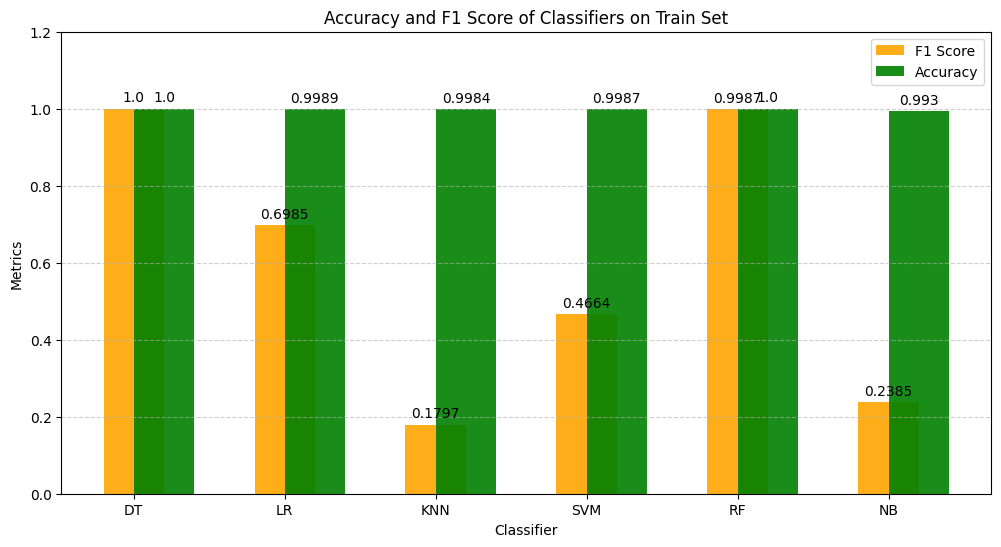

In [43]:
plot_accuracy_and_f1_score_metrics(all_metrics_df, 'Train', 'Accuracy and F1 Score of Classifiers on Train Set')

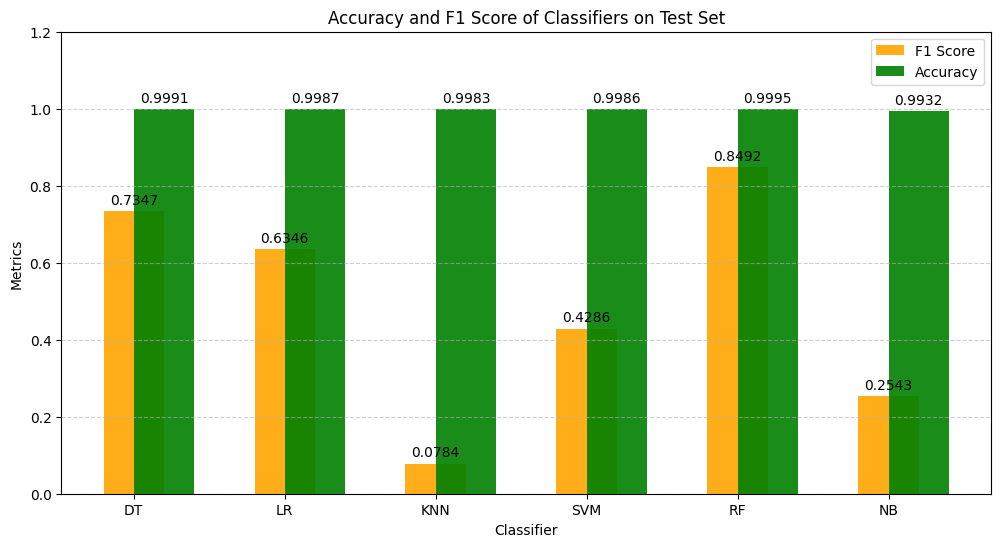

In [44]:
plot_accuracy_and_f1_score_metrics(all_metrics_df, 'Test', 'Accuracy and F1 Score of Classifiers on Test Set')

## Yorumlar

• Başarı Sırası: RF > DT > LR > SVM > NB > KNN
• Her makine öğrenmesi yöntemi her problem seti için uygun değildir.
• Veri seti ön işleme modelin çalışabilmesi / performansı için önemlidir.

## Future Works

* Derin öğrenme yöntemleri üzerinden başarım ölçümü yapılabilir.
* Imbalanced veri setini balanced bir veri seti haline getirerek
sınıflandırma performansları ölçülebilir.
  * Random Oversampling
  * Random Undersampling
  * SMOTE (Synthetic Minority Over-sampling Technique)
* KNN’de yaşanan başarısızlığın düzeltilmesi için çalışma yapılabilir.
* SVM’de farklı kernel parametreleri ve Grid Search ile parametre
optimizayonu yapılabilir.

# References

* https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets